# DeepCell application

### Token for deepcell API
nCDMTpLD.XlCU4Emtpd3FCubSnZqmrCoQo7wzGHuz

download deepcell lib

In [ ]:
pip install deepcell

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.1/498.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 13.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of spektral to determine which versio

In [10]:
import copy
import os

import imageio
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import zipfile

from skimage.io import imread, imsave, imshow
from skimage.transform import resize as imresize
from skimage.color import rgb2gray

import cv2

use pretrained model

In [ ]:
from deepcell.applications import NuclearSegmentation, CellTracking
from deepcell_tracking.trk_io import load_trks

os.environ.update({"DEEPCELL_ACCESS_TOKEN": "nCDMTpLD.XlCU4Emtpd3FCubSnZqmrCoQo7wzGHuz"})
app = NuclearSegmentation()

print('Training Resolution:', app.model_mpp, 'microns per pixel')

430MB [00:20, 22.2MB/s]


Training Resolution: 0.65 microns per pixel


process the Kate Dataset in YOLO format

In [ ]:
path_to_zip_file = "project-9-at-2024-06-13-03-52-b472fec5.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("Data")

In [ ]:
a = np.array([1,2,3])
os.mkdir("Data")
os.mkdir("Data/images")
os.mkdir("Data/labels")
os.mkdir("Data/masks")
np.save("Data/a.npy", a)

In [ ]:
%matplotlib inline


# path variables
img_dir = "Data/images/"
label_dir = "Data/labels/"
mask_dir = "Data/masks/"

for file in os.listdir(img_dir):
    file_name = file.split(".")[0]
    img = np.expand_dims(imread("Data/images/" + file), axis=0)
    img = rgb2gray(img)
    img = np.expand_dims(img, axis=3)
    print(img.dtype, img.shape)
    y_pred = app.predict(img)
    print(y_pred.shape)
    np.save(mask_dir+file_name+".npy", y_pred)

float64 (1, 1040, 1408, 1)
(1, 1040, 1408, 1)


In [ ]:
def shuffle_colors(ymax, cmap):
    """Utility function to generate a colormap for a labeled image"""
    cmap = mpl.colormaps[cmap].resampled(ymax)
    nmap = cmap(range(ymax))
    np.random.shuffle(nmap)
    cmap = ListedColormap(nmap)
    cmap.set_bad('black')
    return cmap

ymax = np.max(y_pred)
cmap = shuffle_colors(ymax, 'tab20')

def plot(x, y):
    yy = copy.deepcopy(y)
    yy = np.ma.masked_equal(yy, 0)

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(x, cmap='Greys_r')
    ax[0].axis('off')
    ax[0].set_title('Raw')
    ax[1].imshow(yy, cmap=cmap, vmax=ymax)
    ax[1].set_title('Segmented')
    ax[1].axis('off')

    fig.canvas.draw()  # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.close(fig)

    return image

imageio.mimsave(
    'labeled.gif',
    [plot(img[i,...,0], y_pred[i,...,0])
     for i in range(y_pred.shape[0])]
)

(-0.5, 49.5, 49.5, -0.5)

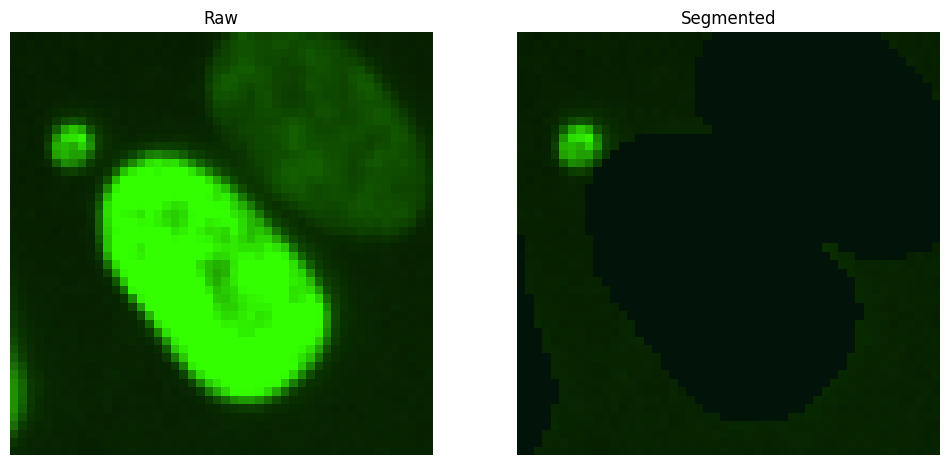

In [ ]:
file = "10 Gy_GFP-H2B_A1_1_2023y06m24d_18h17m"
img = imread("Data/images/" + file + ".png")
mask = np.load("Data/masks/" + file + ".npy")
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img[330:380, 630:680])
ax[0].axis('off')
ax[0].set_title('Raw')

# cover the nuclei part
img_covered = copy.deepcopy(img)
img_covered[mask[0,...,0] > 0, :] = [2, 20, 10]
cmap = matplotlib.cm.spring
cmap.set_bad(color='white')

ax[1].imshow(img_covered[330:380, 630:680], cmap = cmap)
ax[1].set_title('Segmented')
ax[1].axis('off')

### Evaluate

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
! tar -xvf "/content/gdrive/MyDrive/PMCC/result.tar"

work/
work/KateData_yolo/
work/KateData_yolo/classes.txt
work/KateData_yolo/images/
work/KateData_yolo/images/10 Gy_GFP-H2B_A1_1_2023y06m24d_23h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_B1_2_2023y06m24d_18h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_A2_1_2023y06m25d_06h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_A2_1_2023y06m25d_02h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_A1_3_2023y06m25d_03h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_A1_3_2023y06m25d_07h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_A1_3_2023y06m24d_22h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_A1_1_2023y06m25d_21h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_A1_1_2023y06m26d_11h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_B1_2_2023y06m25d_12h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_A2_1_2023y06m24d_23h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_A1_1_2023y06m26d_15h17m.png
work/KateData_yolo/images/10 Gy_GFP-H2B_B1_2_2023y06m25d_16h17m.png
work/KateData_yolo/images/10 Gy_

Evaluate the accuracy of predicted mask and labeled mask.
- Generate a GT mask from yolo seg points format.
- intersect = mask & GT, sum/GT > 0.5 counts as positive
- save mis labeled classes

In [5]:

import sys
sys.path.append('/content/utils')
from yolo_convert import yolo_format_points_to_mask

work_dir = "/content/work/KateData_yolo/"

def evaluate_accuracy(res, img, img_name):
    label_dir = work_dir + "labels/"
    mask_dir = work_dir + "masks/"
    deepcell_mask = np.load(mask_dir + img_name + ".npy")
    deepcell_mask = np.squeeze(deepcell_mask).astype(bool)
    # Open the file in read mode
    with open(label_dir + img_name + ".txt", 'r') as label_file:
        # Read and print each line in the file
        for line in label_file:
            l = line.strip().split()
            # class type:
                #   4: cell_active_div, 5: cell_non_div, 6: cell_sick_apop, 7: micronuclei
            cls, points = int(l[0]), l[1:]
            if cls < 4 or cls > 7:
              continue
            labeled_mask = yolo_format_points_to_mask(points, img.shape).astype(bool)
            intersect = np.logical_and(deepcell_mask, labeled_mask)
            cover = np.sum(intersect) / np.sum(labeled_mask)
            res[cls][0] += 1
            if cover > 0.5:
              res[cls][1] += 1
              res[cls][2] += cover

              # save examples for dividing and mn
              if cls == 4:
                np.save("/content/gdrive/MyDrive/PMCC/mislabels/dividing/" + img_name + ".npy", labeled_mask)
              if cls == 7:
                np.save("/content/gdrive/MyDrive/PMCC/mislabels/mn/" + img_name + ".npy", labeled_mask)

def main():
    img_dir = work_dir + "images/"
    label_dir = work_dir + "labels/"
    mask_dir = work_dir + "masks/"

    res = {}
    for i in range(4,8):
      # record each class [total, matched, coverage]
      res[i] = [0,0,0]

    for file in os.listdir(img_dir):
        img_name = file.split(".")[0]
        img = imread(img_dir+file)
        img_shape = img.shape
        evaluate_accuracy(res, img, img_name)
    for i in range(4,8):
      # record each class [total, matched, coverage]
      res[i][2] /= res[i][1] if res[i][1] != 0 else 1
    print(res)


In [6]:
main()

{4: [249, 9, 0.5411538759136164], 5: [1973, 1970, 0.9787463197224837], 6: [43, 0, 0.0], 7: [385, 135, 0.9066763791864487]}


Display and compare mislabel cases

image x range [563, 569], y range [756, 759]
image x range [707, 712], y range [146, 151]
image x range [458, 462], y range [697, 700]
image x range [211, 223], y range [1206, 1219]
image x range [949, 960], y range [647, 658]
image x range [439, 444], y range [678, 684]
image x range [598, 603], y range [540, 544]
image x range [97, 117], y range [1082, 1102]
image x range [361, 364], y range [87, 92]
image x range [661, 667], y range [74, 80]


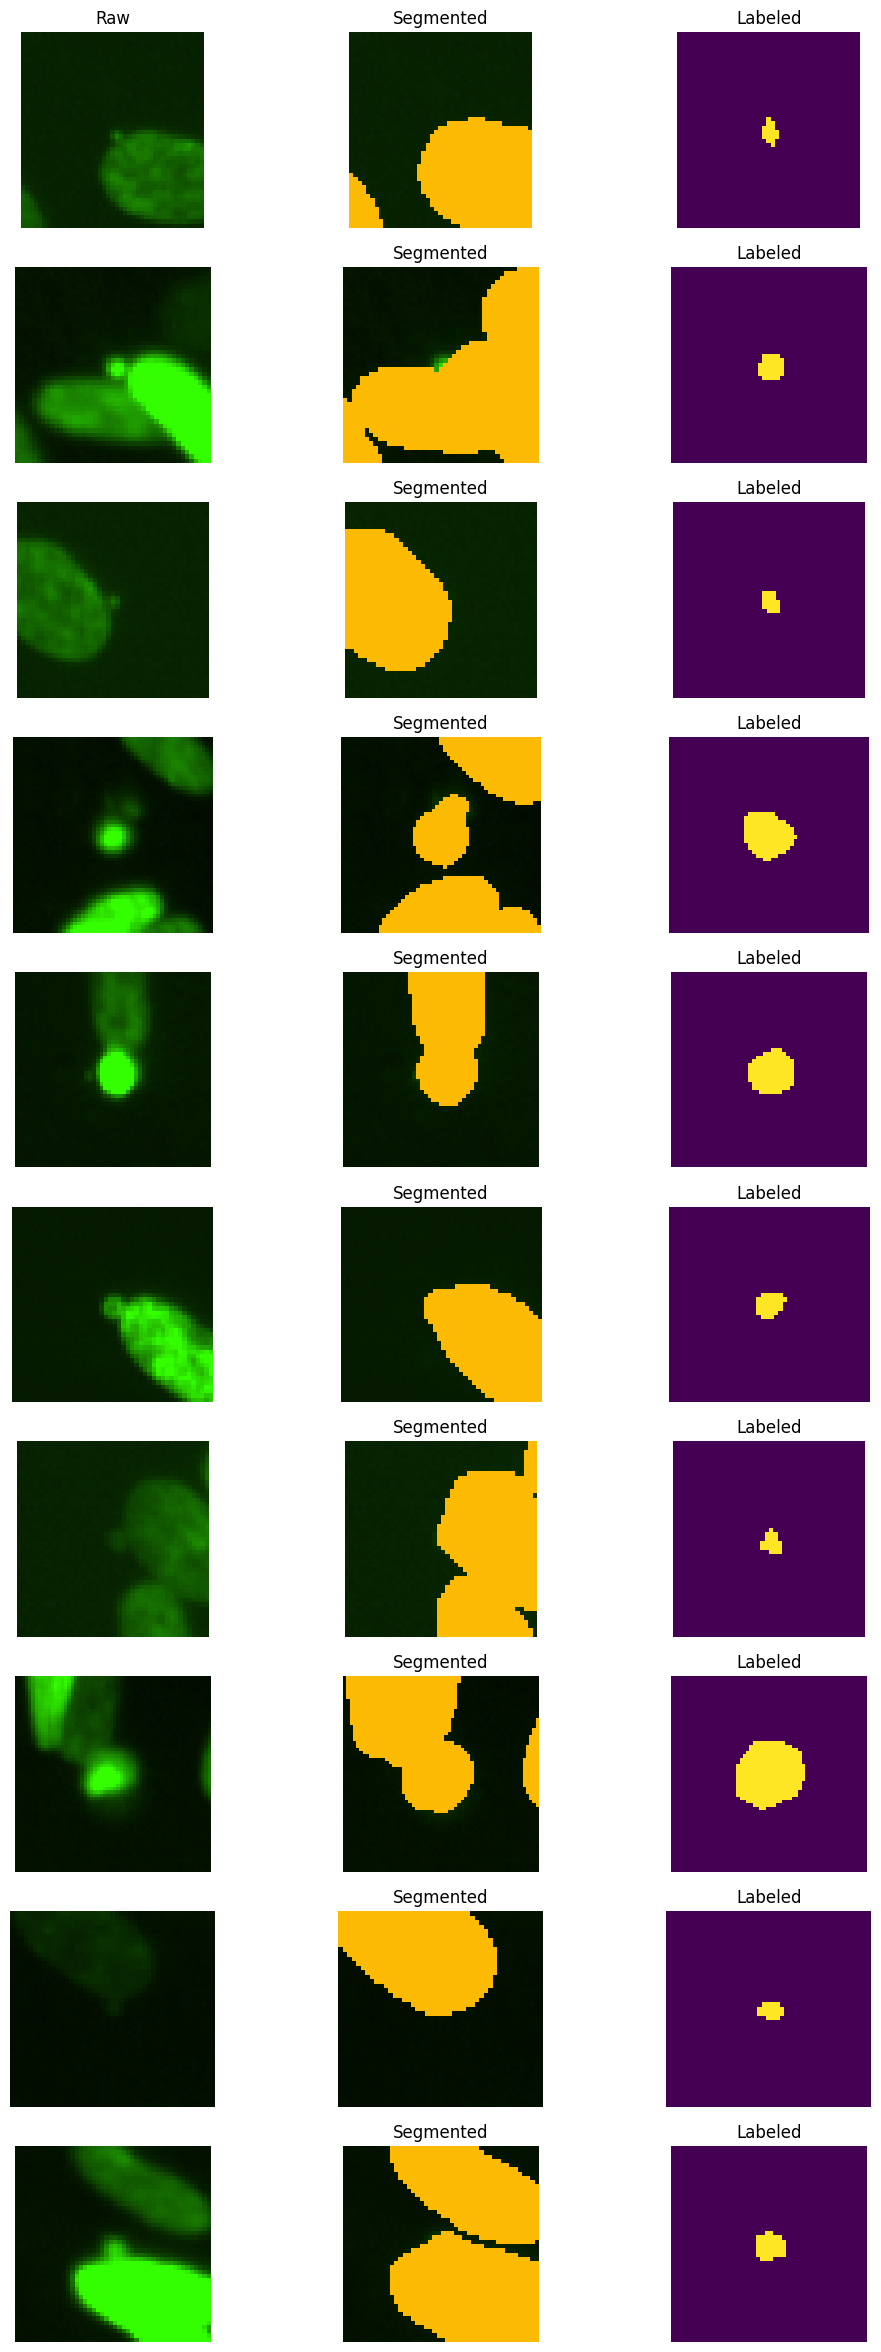

In [39]:
# file = "10 Gy_GFP-H2B_A1_1_2023y06m25d_02h17m"
work_dir = "/content/work/KateData_yolo/"
mislabels_dir = "/content/gdrive/MyDrive/PMCC/mislabels/"

i = 0
fig, ax = plt.subplots(10, 3, figsize=(12, 30))
ax[0][0].set_title('Raw')

for f in os.listdir(mislabels_dir+"mn/"):
  file = f.split(".")[0]

  img = imread(work_dir + "images/" + file + ".png")
  mask = np.load(work_dir + "masks/" + file + ".npy")
  label = np.load(mislabels_dir + "mn/" + file + ".npy")
  x,y = np.where(label>0)
  print(f"image x range [{min(x)}, {max(x)}], y range [{min(y)}, {max(y)}]")
  range_x = [min(x)-20, max(x)+20]
  range_y = [min(y)-20, max(y)+20]

  ax[i][0].imshow(img[range_x[0]:range_x[1], range_y[0]:range_y[1]])
  ax[i][0].axis('off')

  # cover the nuclei part
  img_covered = copy.deepcopy(img)
  img_covered[mask[0,...,0] > 0, :] = [252, 186, 3]

  ax[i][1].imshow(img_covered[range_x[0]:range_x[1], range_y[0]:range_y[1]])
  ax[i][1].set_title('Segmented')
  ax[i][1].axis('off')

  ax[i][2].imshow(label[range_x[0]:range_x[1], range_y[0]:range_y[1]])
  ax[i][2].axis('off')
  ax[i][2].set_title('Labeled')

  i += 1
  if i == 10:
    break

### yolo to mask test

(1040, 1408)
(1040, 1408)


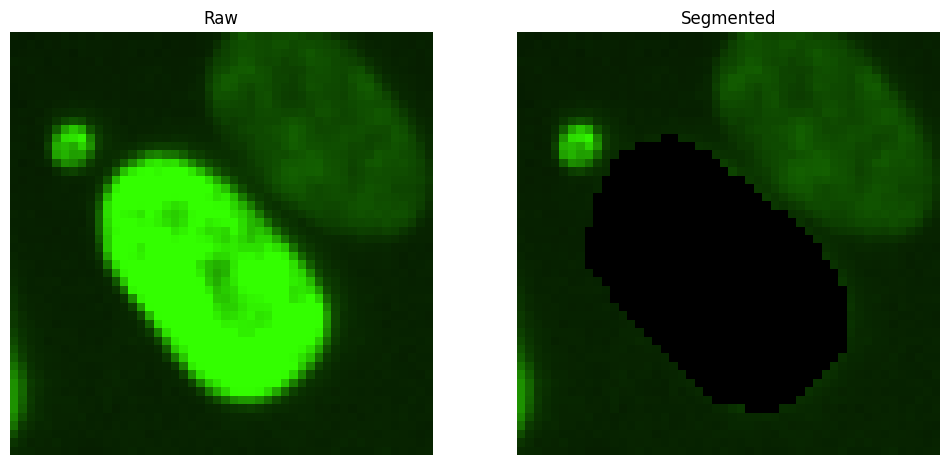

In [ ]:
import copy
import os

import imageio
import matplotlib
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon

file = "10 Gy_GFP-H2B_A1_1_2023y06m24d_18h17m"
img = imread("Data/images/" + file + ".png")
mask = np.load("Data/masks/" + file + ".npy")
mask = np.squeeze(mask)
print(mask.shape)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img[330:380, 630:680])
ax[0].axis('off')
ax[0].set_title('Raw')
img_shape = img.shape
with open("Data/labels/" + file + ".txt", 'r') as label_file:
    # Read and print each line in the file
    for line in label_file:
        l = line.strip().split()
        cls, points = l[0], l[1:]
        if cls == "7":
          continue
        points = np.array(points).astype(float)
        points = points.reshape(-1,2)
        xy_length = np.array([img_shape[1], img_shape[0]])
        points = points*xy_length
        # print(points)
        mask = points_to_mask(points, img_shape[:2]).astype(bool)
        print(mask.shape)
        img_covered = copy.deepcopy(img)
        # print(np.where(mask == 255))
        img_covered[mask, :] = [0, 0, 0]
        ax[1].imshow(img_covered[330:380, 630:680])
        ax[1].set_title('Segmented')
        ax[1].axis('off')
        break

# Yolo

In [ ]:
from ultralytics import YOLO

In [ ]:


# Load a model
model = YOLO("yolov8n-seg.yaml")  # build a new model from YAML
model = YOLO("yolov8n-seg.pt")  # load a pretrained model (recommended for training)
model = YOLO("yolov8n-seg.yaml").load("yolov8n.pt")  # build from YAML and transfer weights

# Train the model
results = model.train(data="coco8-seg.yaml", epochs=100, imgsz=640)

# TensorFlow Tut

In [ ]:
# pip install numpy tensorflow sklearn scipy
# conda install numpy tensorflow sklearn scipy

import numpy as np

from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

KeyboardInterrupt: 

In [ ]:
num_classes = 10  # mnist is the 10 digits

# load the data, split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

In [ ]:
# Reshape data if necessary

# Add the channel dimension to the raw data.
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# normalize the data: set pixel values to be in range [0, 1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('First 10 values of y_train:', y_train[:10])

In [ ]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 5)
for i in range(5):
  axis[i].imshow(X_train[i], cmap = 'gray')
# print(X_train[i,...,0])
fig.tight_layout()
fig.show()

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Our current shape is (batches, rows, cols, channels) but SVC expects (batches, pixels)
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

model = LinearSVC()

model.fit(X_train_reshaped, y_train)

predictions = model.predict(X_test_reshaped)
print(classification_report(y_test, predictions))
print('Accuracy Score:', accuracy_score(y_test, predictions))

In [ ]:
# Using the keras to_categorical function to one-hot encode the data

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(y_train[:10])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# augmentation rules define the affine transform matrix to apply to the data
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=30)
# View the augmented data
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(5, 5), sharex=True, sharey=True)
ax = axes.ravel()

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        ax[i].imshow(X_batch[i, ..., 0], cmap='gray')
        ax[i].set_title(np.argmax(y_batch[i]))

    fig.tight_layout()
    plt.show()
    break

In [ ]:
inputs = Input(shape=X_train.shape[1:])
flat = Flatten()(inputs)
dense = Dense(10, activation='softmax')(flat) # output is softmax(dot(X, W) + bias)

model = Model(inputs=inputs, outputs=dense)

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])

loss = model.fit(X_train, y_train,
                 batch_size=128,
                 epochs=5,
                 verbose=1,
                 validation_data=(X_test, y_test))

In [ ]:
# Create a model with the Keras Sequential API

model = Sequential()
# 32 3x3 filters (extracting 5x5-pixel subregions), with ReLU activation
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=X_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # Apply max filter to every 2x2 patch
model.add(Dropout(0.25)) # Drop 25% of inputs to prevent overfitting
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=SGD(momentum=0.9, nesterov=True),
              metrics=['accuracy'])

# Now using the ImageDataGenerator
loss = model.fit_generator(datagen.flow(X_train, y_train, batch_size=128),
                           steps_per_epoch=X_train.shape[0] // 128,
                           epochs=3,
                           verbose=1,
                           validation_data=(X_test, y_test))

# Image

int32 (1080, 1280)
Loaded array is of type: <class 'numpy.ndarray'>


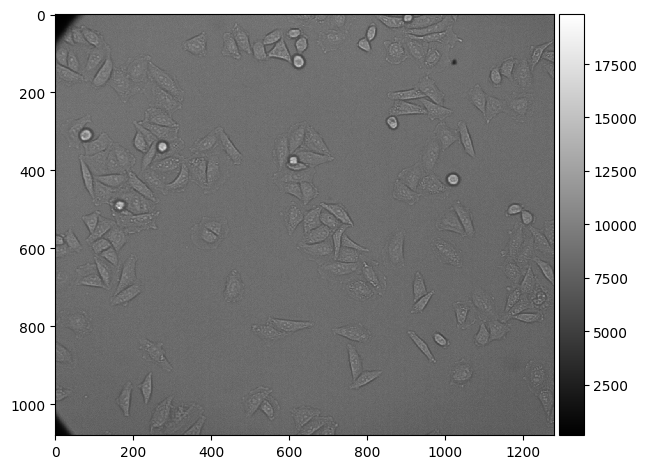

In [ ]:
%matplotlib inline

import numpy as np

from skimage.io import imread, imsave, imshow
from skimage.transform import resize as imresize
from skimage.color import rgb2gray

file_name = r'img_000000000_Phase_000.png'
# Read an JPEG image into a numpy array
#img = imread('resources/img_000000000_Phase_000.png')
img = imread(file_name)
# img = rgb2gray(img)
print(img.dtype, img.shape)

# img_tin = imresize(img * [1.0, 0.95, 0.1], (400, 400))
imshow(img, cmap='gray')
print("Loaded array is of type:", type(img))

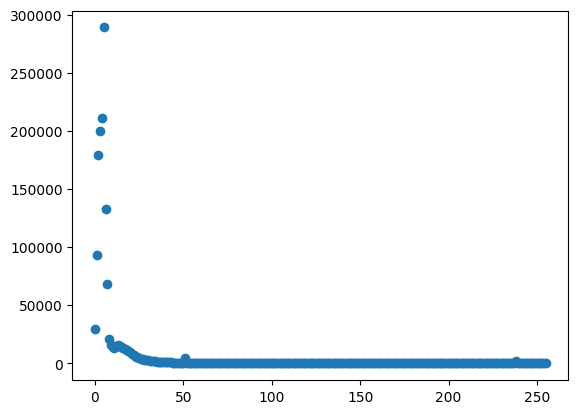

In [ ]:
import matplotlib.pyplot as plt
from skimage.exposure import histogram

# compute histogram in Red channel of cat image
(counts, bins) = histogram(img[:, :, 0])
# view histogram
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(bins,counts)

/usr/local/lib/python3.10/dist-packages/imageio/plugins/pillow.py:304: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


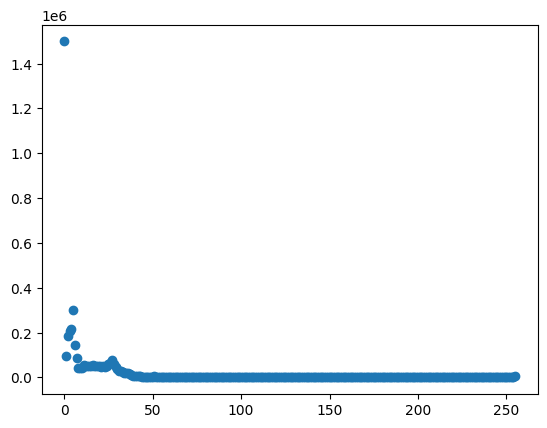

In [ ]:
# compute cell histogram
phase_image = imread("img_000000000_Phase_000.png")
phase_image_float = phase_image/phase_image.max()
(counts, bins) = histogram(phase_image_float)

(counts, bins) = histogram(img)
# view cell histogram
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(bins, counts)

/usr/local/lib/python3.10/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


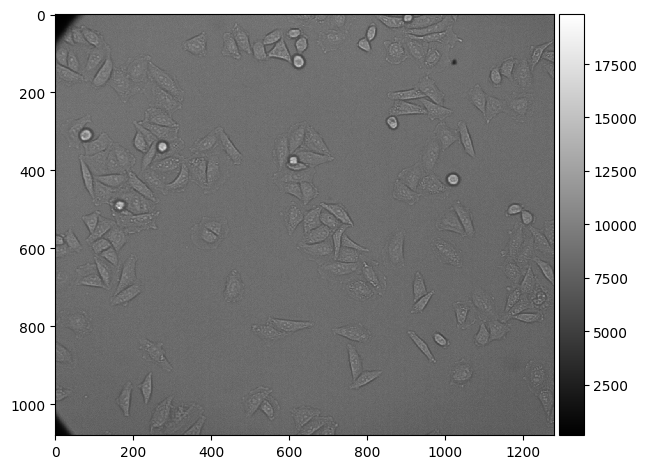

In [ ]:
imshow(phase_image, cmap= 'gray')